In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from matplotlib import pyplot as plt
from PIL import Image
from numpy import asarray
from numpy import array
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from numpy import expand_dims
from numpy import reshape
from numpy import load
from numpy import max
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC


def extract_image(image):
    img1 = Image.open(image)
    img1 = img1.convert('RGB')
    pixels = asarray(img1)
    detector = MTCNN()
    f = detector.detect_faces(pixels)
    x1, y1, w, h = f[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2 = abs(x1 + w)
    y2 = abs(y1 + h)
    store_face = pixels[y1:y2, x1:x2]
    image1 = Image.fromarray(store_face, 'RGB')
    image1 = image1.resize((160, 160))
    face_array = asarray(image1)
    return face_array


# extracting embeddings
def extract_embeddings(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    mean = face_pixels.mean()
    std = face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    samples = expand_dims(face_pixels, axis=0)
    yhat = model.predict(samples)
    return yhat[0]

In [2]:
%matplotlib inline

In [3]:
# load data and reshape the image
Img = 'data/cv/indian_example/Indian-celebrities/Irrfan_Khan/Irrfan_Khan_0.jpg'
# plt.imshow(Img)
face = extract_image(Img)
testx = asarray(face)
testx = testx.reshape(-1, 160, 160, 3)
print("Input test data shape: ", testx.shape)

Input test data shape:  (1, 160, 160, 3)


In [4]:
# find embeddings
model = load_model('data/cv/indian_example/facenet_keras.h5')
new_testx = list()
for test_pixels in testx:
    embeddings = extract_embeddings(model, test_pixels)
    new_testx.append(embeddings)
new_testx = asarray(new_testx)
print("Input test embedding shape: ", new_testx.shape)

Input test embedding shape:  (1, 128)


### load raw data

In [5]:
data1 = load('data/cv/indian_example/Indian-celeb-dataset.npz')
train_x, train_y = data1['arr_0'], data1['arr_1']

In [6]:
train_x.shape

(1535, 160, 160, 3)

In [7]:
train_y.shape

(1535,)

### load embedded data

In [8]:
data = load('data/cv/indian_example/Indian-celeb-embeddings.npz')
trainx, trainy = data['arr_0'], data['arr_1']
print("Loaded data: Train=%d , Test=%d" % (trainx.shape[0], new_testx.shape[0]))

Loaded data: Train=1535 , Test=1


In [9]:
trainx.shape

(1535, 128)

In [10]:
trainy[:5]

array(['Alia_Bhatt', 'Alia_Bhatt', 'Alia_Bhatt', 'Alia_Bhatt',
       'Alia_Bhatt'], dtype='<U20')

### normalize the input data

In [11]:
# normalize the input data
in_encode = Normalizer(norm='l2')
trainx = in_encode.transform(trainx)
new_testx = in_encode.transform(new_testx)

# create a label vector
new_testy = trainy
out_encode = LabelEncoder()
out_encode.fit(trainy)
trainy = out_encode.transform(trainy)
new_testy = out_encode.transform(new_testy)

In [12]:
# define svm classifier model
model = SVC(kernel='linear', probability=True)
model.fit(trainx, trainy)

# predict
predict_train = model.predict(trainx)
predict_test = model.predict(new_testx)

In [13]:
predict_test

array([33])

In [14]:
# get the confidence score
probability = model.predict_proba(new_testx)
confidence = max(probability)

In [19]:
probability.max()

0.17540476531954508

In [19]:
# Accuracy
acc_train = accuracy_score(trainy, predict_train)
print(acc_train)

0.9986996098829649


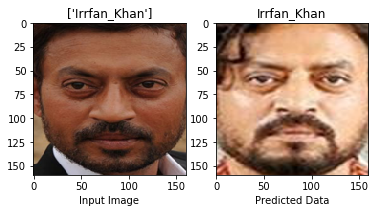

In [20]:
# display
trainy_list = list(trainy)
p = int(predict_test)
if p in trainy_list:
    val = trainy_list.index(p)
# display Input Image
plt.subplot(1, 2, 1)
plt.imshow(face)
predict_test = out_encode.inverse_transform(predict_test)
plt.title(predict_test)
plt.xlabel("Input Image")
# display Predicated data
plt.subplot(1, 2, 2)
plt.imshow(train_x[val])
trainy = out_encode.inverse_transform(trainy)
plt.title(trainy[val])
plt.xlabel("Predicted Data")
plt.show()